In [36]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from torch.utils.data import Dataset,DataLoader
from torchvision.utils import make_grid as vutils
from torchvision import transforms
from torch.optim import lr_scheduler
import random
import os
import cv2
import torch.optim as optim 
from tqdm import tqdm
import time
import copy
from PIL import Image
import joblib

In [37]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda") if torch.backends.cuda.is_built() else torch.device("cpu")
lr = 0.001
epochs = 16
batch_size = 16
gamma = 0.5
csv_combine = pd.read_csv("../data/csv/train.csv")
csv_test = pd.read_csv("../data/csv/test.csv") 
image_dim = 418

In [38]:
class_id = {}
for i,cl in enumerate(csv_combine.class_id.unique()):
    class_id[cl] = i
nclass = i+1 

In [39]:
csv_train = csv_combine
train_size = len(csv_train)
test_size = len(csv_test)

In [40]:
csv_train.head()

,Unnamed: 0,binomial,country,continent,genus,family,UUID,class_id,snake_sub_family,poisonous,X,Y,height,width
0,0,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,20e23008100d4e249fd757c11fe059fe,18,Agkistrodon contortrix,1,0.507412,0.546939,0.916220,0.951425
1,1,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,0c6d14f33f404013ab116ab09880c523,18,Agkistrodon contortrix,1,0.503115,0.392086,0.835316,0.965363
2,2,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,3a31a32de0434653b4a82a30806f7a6d,18,Agkistrodon contortrix,1,0.353031,0.573312,0.652700,0.709286
3,3,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,1c5a3b2953c84d698fad8a40db91323e,18,Agkistrodon contortrix,1,0.436368,0.447794,0.918880,0.834457
4,4,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,e10c99a58c2546dab2c0d998de1f7c1b,18,Agkistrodon contortrix,1,0.512284,0.519067,0.923202,0.631036


In [41]:
csv_test.head()

,Unnamed: 0,binomial,country,continent,genus,family,UUID,class_id,snake_sub_family,poisonous
0,0,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,ca23ee722e5e4b6ca4b130291b8428f1,18,Agkistrodon contortrix,1
1,1,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,23dfe346fcbf40e7a465b0febf3620be,18,Agkistrodon contortrix,1
2,2,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,2c96953bd06645bdbfa87b180eb72b0f,18,Agkistrodon contortrix,1
3,3,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,e2bcec60b133466380d5c253088765ae,18,Agkistrodon contortrix,1
4,4,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,fd6a488d065e47978c9996734fc1732c,18,Agkistrodon contortrix,1


In [42]:
print("Species".ljust(97)+"No Of Images")
for i in csv_train.binomial.unique():
    print("{} {}".format(i.ljust(100),sum(csv_train.binomial == i)))

Species                                                                                          No Of Images
Agkistrodon contortrix                                                                               180
Agkistrodon piscivorus                                                                               200
Ahaetulla nasuta                                                                                     199
Ahaetulla prasina                                                                                    200
Arizona elegans                                                                                      181
Aspidites melanocephalus                                                                             154
Atractus crassicaudatus                                                                              187
Austrelaps superbus                                                                                  201
Bitis arietans                                    

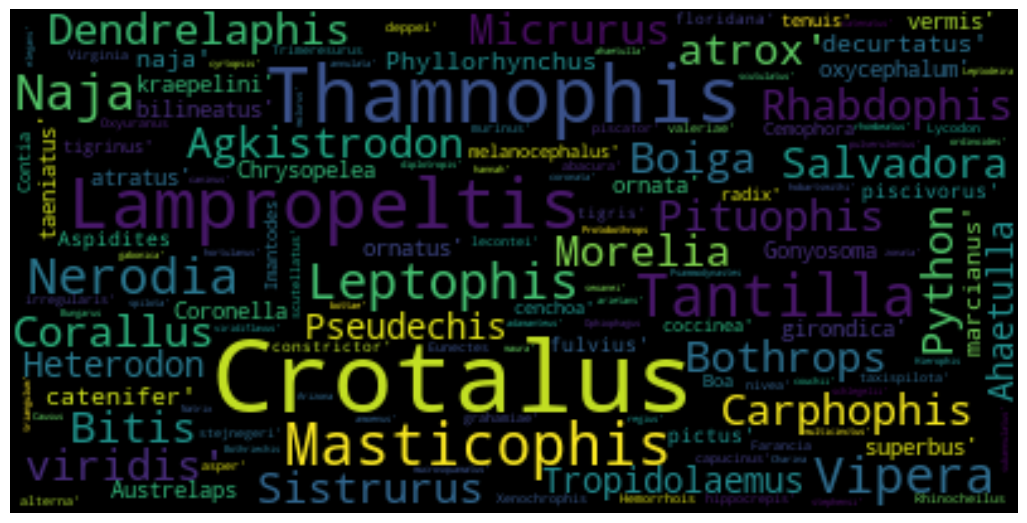

In [43]:
plt.rcParams['figure.figsize']=(13,13)
text = list(set((csv_test.binomial).unique()))
wordcloud = WordCloud(max_font_size=40,max_words=(csv_test.binomial).unique().shape[0]).generate(str(text))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [44]:
# imagefolder = ImageFolder("../input/165-different-snakes-species/train", transform=transforms.ToTensor())
# image_dataloader=DataLoader(imagefolder, batch_size=64, shuffle=True, num_workers=0)

# def batch_mean_and_sd(loader):  
#     cnt = 0
#     fst_moment = torch.empty(3)
#     snd_moment = torch.empty(3)

#     for images, _ in tqdm(loader):
#         b, c, h, w = images.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(images, dim=[0, 2, 3])
#         sum_of_square = torch.sum(images ** 2,
#                                   dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
#         cnt += nb_pixels

#     mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
#     return mean,std

# mean, std = batch_mean_and_sd(image_dataloader)
#
# calculated mean and standard deviation
# mean = [0.4718, 0.4429, 0.3738] , Std = [0.2519, 0.2388, 0.2393]

In [45]:
transformation = {
    "transformation_image": transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(image_dim,image_dim)),
            transforms.Normalize((0.4718, 0.4429, 0.3738),(0.2519, 0.2388, 0.2393))
        ])
}    

transform_aug = transforms.Compose([
    transforms.RandomRotation(360)
])


In [46]:
class Dataset_receiver(Dataset):
    def __init__(self, csv, traindir, device, transform, class_id, aug = None):
        self.csv = csv
        self.traindir = traindir
        self.transform =transform
        self.device = device
        self.class_id = class_id
        self.aug = aug
    def __len__(self):
        return len(self.csv)
    def __getitem__(self, idx):
        
        csv = self.csv.iloc[[idx]]
        cl = csv["class_id"].values[0]
        location = self.traindir + "/" + str(cl) + "/" + csv["UUID"].values[0] + ".jpg"
        bbox = []
        image = Image.open(location)
        key = str(cl) + csv["UUID"].values[0]
        if self.aug != None:
            image = self.aug(image)
            
        image = np.array(image)

        
        # now [x center , y center , width , height]  
        shape = image.shape[0]
        try:
            x,y,width,height = [csv.X, csv.Y, csv.width, csv.height] * shape
            x0 ,y0 = int(x-(width/2)) ,int(y-(height/2))
            x1 ,y1 = int(x+(width/2)) ,int(y+(height/2))

            if x0 < 0:
                x0=0
            if x1 > shape:
                x1 = shape
            if y0 < 0:
                y0 = 0
            if y1 > shape:
                y1 = shape

            processed_image = self.transform["transformation_image"](image[y0:y1, x0:x1])
            return processed_image, torch.tensor(self.class_id[cl]) 
        except:
            processed_image = self.transform["transformation_image"](image)
            return processed_image, torch.tensor(self.class_id[cl])


In [47]:
train_dataset_aug = Dataset_receiver(csv_train, "../data/train/", device, transformation, class_id, transform_aug)
train_dataset_normal = Dataset_receiver(csv_train, "../data/train/", device, transformation, class_id)
test_dataset = Dataset_receiver(csv_test, "../data/test/", device, transformation, class_id)

train_dataset = train_dataset_aug + train_dataset_normal
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


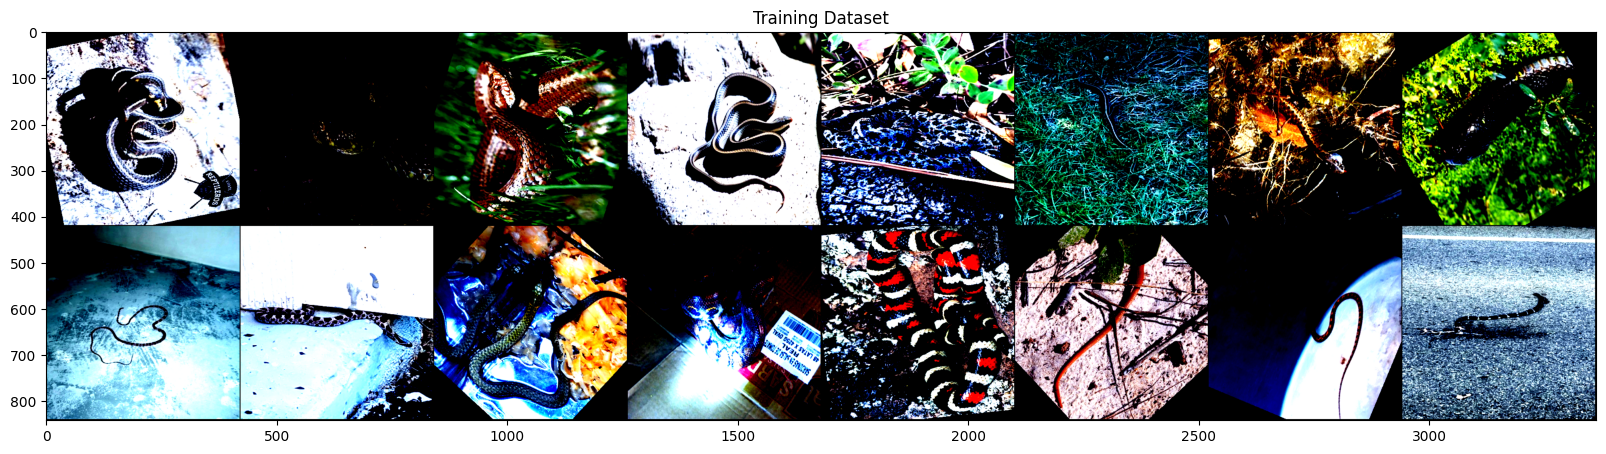

In [48]:
a,_ = next(iter(train_dataloader))
plt.figure(figsize=(20,20))
plt.title("Training Dataset")
plt.imshow(torch.swapdims(torch.swapdims(vutils(a,8,2),0,2),0,1))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


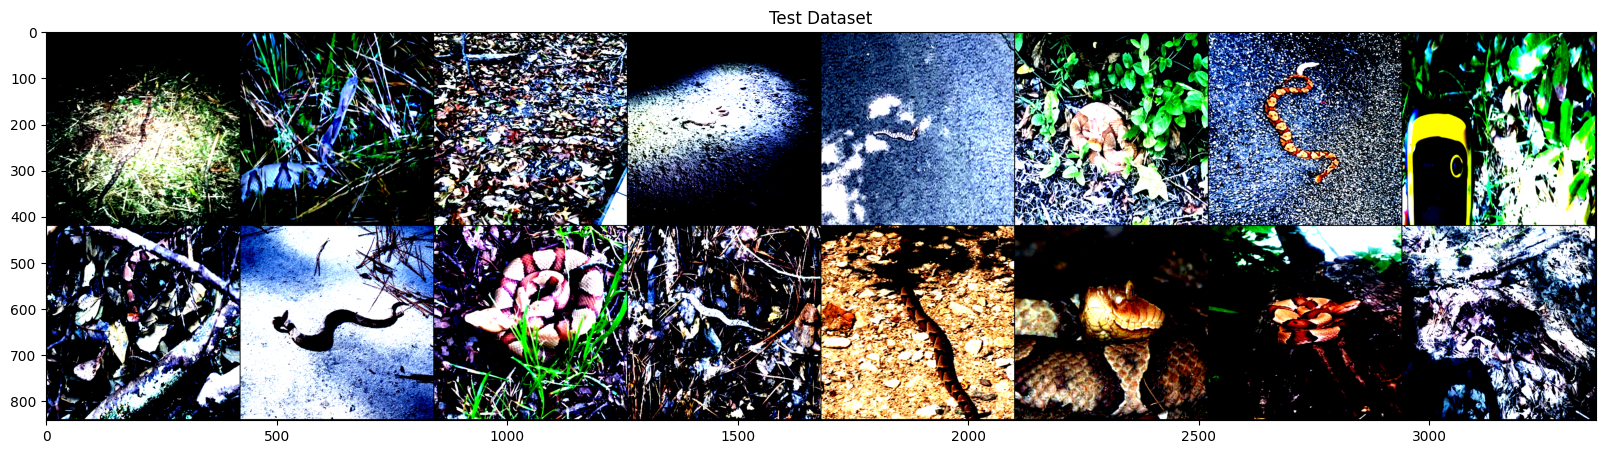

In [49]:
a,_ = next(iter(test_dataloader))
plt.figure(figsize=(20,20))
plt.title("Test Dataset")
plt.imshow(torch.swapdims(torch.swapdims(vutils(a,8,2),0,2),0,1))
plt.show()

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, verbose = 1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                dataloaders=train_dataloader
                model.train()  # Set model to training mode
                dataset_sizes=train_size*2

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if verbose == 1:
                loop = tqdm(dataloaders)
            else:
                loop = dataloaders
            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()* inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if verbose == 1:
                    loop.set_postfix(loss=loss.item())
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def accuracy(dataloader, model):
    model.eval()
    result = []
    output = []
    label = []
    with torch.no_grad():
        for i, j in tqdm(dataloader):
            out = model(i.to(device))
            out = out.argmax(dim = 1).to(torch.device("cpu"))
            result += (j == out).tolist()
            output += out.tolist()
            label += j.tolist()
    print("Accuarcy Of the Test set: ",sum(result)/len(result))  
    return output, label
            

In [51]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b4', pretrained=True)
model.classifier.fc = nn.Linear(model.classifier.fc.in_features, nclass)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=gamma)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1002)>

In [ ]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=epochs, verbose = 0)
output, label = accuracy(test_dataloader, model)
output, label = np.array(output), np.array(label)

In [ ]:
id_name = list(class_id.values())

In [ ]:
def Precision_recall(label, output, class_id):
    precision = []
    recall = []
    print("{}{}{}{}".format("Label".ljust(20), "Accuracy".ljust(20), "Precision".ljust(20), "Recall".ljust(20)))
    for i in list(class_id):
        label_truth = np.array(label) == i
        output_truth = np.array(output) == i
        temp_tp = label[label_truth] == output[label_truth]
        temp_fp = sum(output_truth) - sum(label_truth * output_truth)
        temp_fn = sum(label_truth) - sum(label_truth * output_truth)
        p = sum(temp_tp)/((sum(temp_tp)+temp_fp) if (sum(temp_tp)+temp_fp) != 0 else 1)
        r = sum(temp_tp)/((sum(temp_tp)+temp_fn) if (sum(temp_tp)+temp_fn) != 0 else 1)
        precision.append(p)
        recall.append(r)
        print("{}{}{}{}".format(str(i).ljust(20), str(sum(temp_tp)/len(temp_tp)).ljust(20), str(p).ljust(20), str(r).ljust(20)))    
    precision = sum(precision)/len(precision)
    recall = sum(recall)/len(recall)
    f1_score = 2*(precision*recall)/(precision+recall)
    print("F1 Score : {}".format(f1_score))
    return f1_score
torch.save(model,'model_snakes.pt')

In [ ]:
Precision_recall(label, output, id_name)